### Load the Commit Statistics
For this clustering we examined 39 GitHub projects containing a total of 2,629 commits. The projects all included the Fluence Marine library. Code for Fluence is generally written in React and Rust.

In [1]:
project_root_path = '../../..'
lib_path = project_root_path + '/python/lib/'
import json
import sys
sys.path.append(lib_path)
import commit_features

dataset_dir = project_root_path + '/data/github/2022-04-07-marine-search'
dataset_dir = project_root_path + '/sandbox/data/bob'
project_stats_dir = dataset_dir + '/projects'
project_stats_dir = dataset_dir + '/new_repos'
file_name = 'commit-stat.log.json'
file_name = 'commit_stat.json'
all_commit_features = commit_features.load_all(project_stats_dir, file_name)

### Analyze the Text Line Features
Look at the available fields that we might use and decide which ones we will use.

In [2]:
possible_names = [feature_name for feature_name in all_commit_features[0].keys() if feature_name.endswith('Lines')]
str(possible_names)

"['textLines', 'clojureLines', 'configurationLines', 'datascienceLines', 'gitignoreLines', 'htmlLines', 'javascriptLines', 'jsonLines', 'lockLines', 'markdownLines', 'noexttextLines', 'pydataLines', 'pythonLines', 'rustLines', 'shellLines', 'solidityLines', 'txtLines', 'yarnLines']"

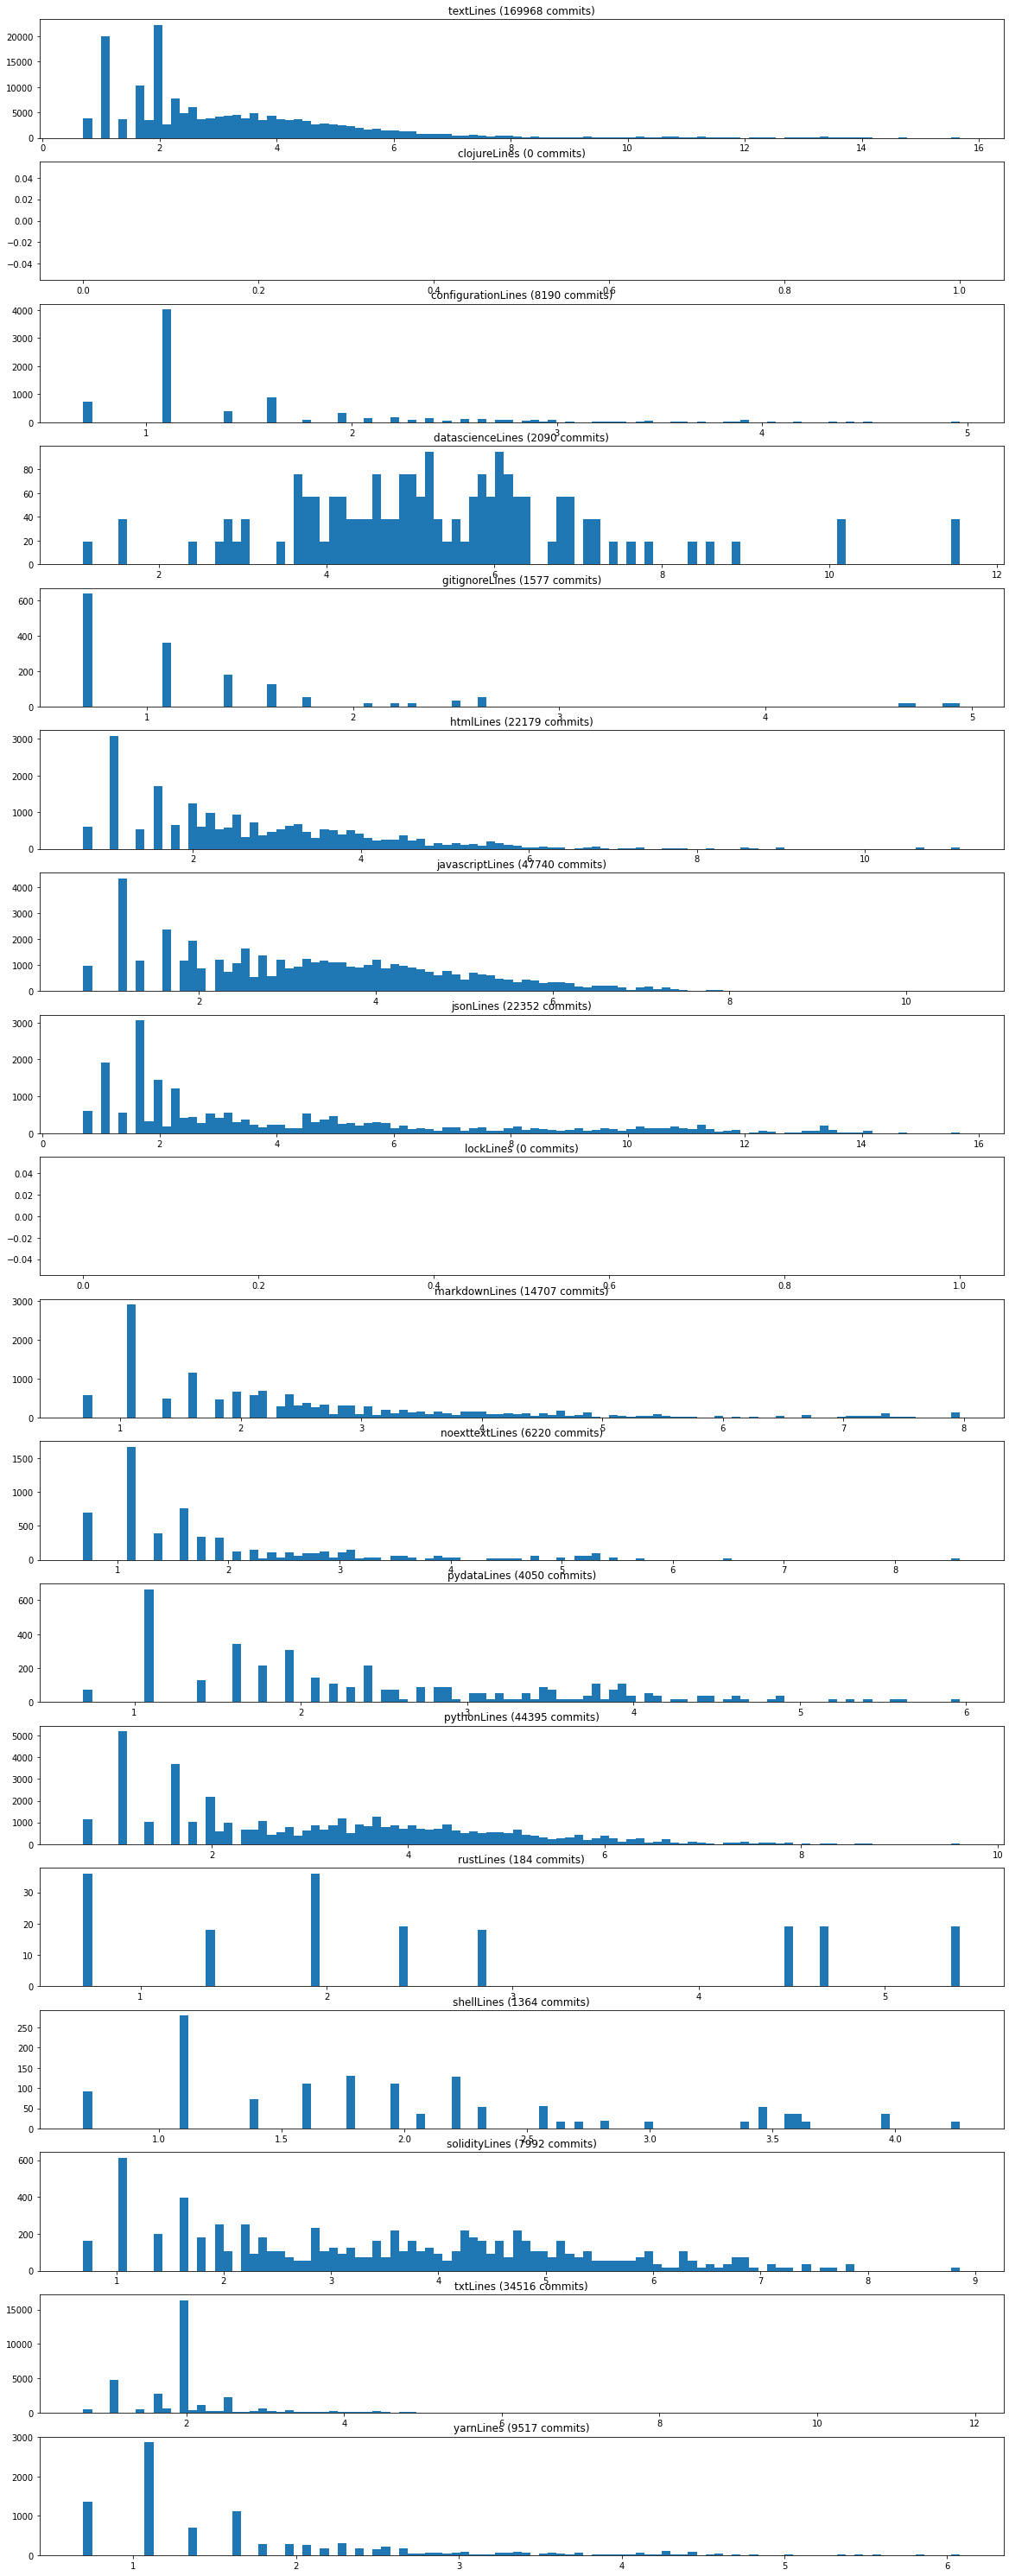

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def log1p_array(feature_set, feature_name):
    return [np.log1p(features[feature_name]) for features in feature_set if features[feature_name] > 0]

def hist_me_with_your_best_shot(axis, stats_set, stat_name):
    logarray = log1p_array(stats_set, stat_name)
    axis.hist(logarray, 100)
    axis.set_title(stat_name + " (" + str(len(logarray)) + " commits)")

num_plots = len(possible_names)
height = num_plots * 3
fig, axs = plt.subplots(num_plots, 1, figsize=(20,height))

i = 0
for feature_name in possible_names:
    hist_me_with_your_best_shot(axs[i], all_commit_features, feature_name)
    i += 1

plt.show()

### Select The Features
This clustering is for data analysis, not production. I am intentionally excluding the aggregate statistics - binFiles, textFiles, and textLines - from the list of input features. This prevents the ML model from taking a short-cut with those potentially over-powered statistics. My goal here is to see how effective the finer-grained statistics are.

I also tested with binFiles, textFiles, and textLines included. The results are nearly identical and not sufficiently illuminating to warrant inclusion here.

In [4]:
import numpy as np

include_features = [
    'binFiles', 'imgFiles', 'textFiles', 'textLines', 'configurationLines',
    'datascienceLines', 'htmlLines', 'javascriptLines', 'jsonLines',
    'markdownLines', 'noexttextLines', 'pydataLines', 'pythonLines',
    'solidityLines', 'txtLines', 'yarnLines'
]

feature_names = [
    'javascriptLines', 'rustLines', 'markdownLines', 'jsonLines','lockLines',
    'htmlLines', 'imgFiles', #  'shellLines', 'yarnLines', 
]
feature_names = include_features
X = [[np.log1p(features[feature_name]) for feature_name in feature_names] for features in all_commit_features]
X[slice(5)]

[[0.0,
  0.0,
  1.3862943611198906,
  7.968665700466235,
  0.0,
  0.0,
  0.0,
  0.0,
  1.6094379124341003,
  7.9672801789422,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.0,
  0.0,
  1.0986122886681096,
  4.77912349311153,
  0.0,
  0.0,
  0.0,
  0.0,
  4.77912349311153,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.0,
  0.0,
  1.3862943611198906,
  2.70805020110221,
  0.0,
  0.0,
  0.0,
  0.0,
  1.9459101490553132,
  2.1972245773362196,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.0,
  0.0,
  0.6931471805599453,
  1.0986122886681096,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0986122886681096,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.0,
  0.0,
  1.3862943611198906,
  3.044522437723423,
  0.0,
  0.0,
  0.0,
  0.0,
  1.9459101490553132,
  2.70805020110221,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0]]

### Clustering with Eight Centers
Exploring various numbers of centers, eight gives us a good impression of the quality of information we are getting from this feature set.

In [5]:
from sklearn.cluster import KMeans

num_clusters = 15
random = 0

y_pred = KMeans(n_clusters=num_clusters, random_state=random).fit_predict(X)

### Histogram of Cluster Sizes
Looking at a histogram of cluster sizes can show if there are major anomolies. In this case we have a reasonable distribution of cluster sizes. 

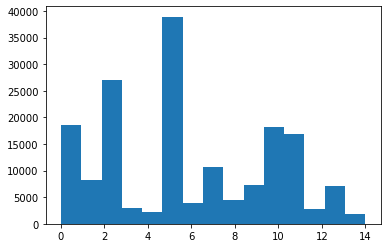

In [6]:
import matplotlib.pyplot as plt

plt.hist(y_pred, num_clusters)
plt.show()

### Reshape the Stats for Easier Handling

In [7]:
for i in range(0, len(y_pred)):
    all_commit_features[i]['cluster'] = y_pred[i]
    
clusters = [i for i in range(0, num_clusters)]
for i in range(0, num_clusters):
    clusters[i] = [stats for stats in all_commit_features if stats['cluster'] == i]

### Show Median Statistics for Each Cluster
The table generated here has median values for each cluster to facilitate interpetation of the data. The output fields shown were not included directly as input features, though they are dependent variables.

In [8]:
import numpy as np
import pandas as pd

cluster_names = ['#' + str(i) for i in range(0,len(clusters))]

fields = ['numCommits', 'binFiles', 'textFiles', 'textLines',
          'javascriptLinePct', 'rustLinePct', 'markdownLinePct', 'jsonLinePct',
          'lockLinePct', 'htmlLinePct', 'imgFilePct'] # , 'shellLinePct' , 'yarnLinePct'

fields = [
    'numCommits', 'binFiles', 'imgFilePct', 'textFiles', 'textLines',
    'configurationLinePct',
    'datascienceLinePct', 'htmlLinePct', 'javascriptLinePct', 'jsonLinePct',
    'markdownLinePct', 'noexttextLinePct', 'pydataLinePct', 'pythonLinePct',
    'solidityLinePct', 'txtLinePct', 'yarnLinePct'
] # , 'shellLinePct' , 'yarnLinePct'

for cluster in clusters:
    numCommits = len(cluster)
    for stats in cluster:
        stats['numCommits'] = numCommits

data = [[int(np.round(np.median([stats[field] for stats in cluster]))) for field in fields] for cluster in clusters]
cluster_df = pd.DataFrame(data, index=cluster_names, columns=fields)
cluster_df.transpose()

,#0,#1,#2,#3,#4,#5,#6,#7,#8,#9,#10,#11,#12,#13,#14
numCommits,18615,8237,27083,2906,2142,38910,3828,10620,4413,7218,18095,16894,2754,7108,1767
binFiles,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
imgFilePct,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
textFiles,2,7,1,45,24,1,2,4,8,3,2,2,4,3,1
textLines,17,273,6,53798,535,2,469,120,142,32,9,39,100,23,288
configurationLinePct,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
datascienceLinePct,0,0,0,0,0,0,0,0,0,0,0,0,0,0,100
htmlLinePct,0,0,0,0,0,0,0,0,26,100,0,0,0,0,0
javascriptLinePct,100,0,0,0,38,0,0,100,69,0,0,0,0,0,0
jsonLinePct,0,0,0,100,43,0,100,0,0,0,0,0,0,0,0


### Interpreting the Clusters
Each datapoint above is a median value of the commits in the cluster.
#### Cluster #0: Small Javascript Development Commits
Small # of lines of Javascript shows these are standard JS developer commits.
#### Cluster #1: Large Python Development
Large # of lines of Python, but smaller than a bulk commit. Maybe stock code? Flag it separately and get a sample.
#### Cluster #2: Small .txt Commits
Small # of lines in a single .txt file. Flag it and get a sample.
#### Cluster #3: Huge JSON Commits
Huge # of lines of JSON in many files means these are not hand-coded. Flag it and get a sample.
#### Cluster #4: JS Toolkit Commit
Large # of lines and files, Javascript and JSON. I suspect these are toolkit / library commits. Flag it and get a sample.
#### Cluster #5: Bugfixes & Tweaks
Small commits that address a single problem. Could be code or documentation. Median values in this chart hide the specific type - the code type will be retained in the final pipeline.
#### Cluster #6: Big JSON Commits
Large # of lines of JSON in few files. Could be hand-coded or generated data. Flag it and get a sample.
#### Cluster #7: Medium Javascript Development Commits
Medium # of lines of Javascript shows these are standard JS developer commits. Flag and sample, probably winds up with Javascript Development.
#### Cluster #8: 



#### Cluster #3: Rust Packaging Commits
A bit more Rust than in a Rust Development Commit plus some "lock" lines. ".lock" files are associated with the Rust package manager, Cargo.
#### Cluster #5: Documentation Commits
26 lines of markdown identifies these documentation commits.
#### Cluster #6: HTML Commits
41 lines of HTML (including CSS) mark these as web interface commits.



### Sample by Cluster ID

In [9]:
import numpy as np
import pandas as pd

to_be_labeled = []
fields = ['label', 'cluster','binFiles', 'textFiles', 'textLines',
          'javascriptLinePct', 'rustLinePct', 'markdownLinePct', 'jsonLinePct',
          'imgFiles', 'lockLinePct', 'htmlLinePct']
commit_ids = []
for cluster in clusters:
    sample = np.random.choice(cluster, size=40, replace=False)
    for commit in sample:
        commit['label'] = ''
        to_be_labeled.append([commit[field] for field in fields])
        commit_ids.append(commit['commit'])

In [10]:
cluster_df = pd.DataFrame(to_be_labeled, index=commit_ids, columns=fields)
cluster_df.to_csv(project_root_path + '/sandbox/data/bob/commit_labeling.tsv', sep="\t")
cluster_df

,label,cluster,binFiles,textFiles,textLines,javascriptLinePct,rustLinePct,markdownLinePct,jsonLinePct,imgFiles,lockLinePct,htmlLinePct
46d7fa2ea11f30ca61ad1ea1df732595aafde243,,0,0,1,18,100.0,0.0,0.0,0.00,0,0,0.0
9c04e22b84fc469d481edef0645ab182e6f6b1b6,,0,0,4,26,100.0,0.0,0.0,0.00,0,0,0.0
a82a8e6a8627bf57221c6c923480da5185a9715c,,0,0,2,10,100.0,0.0,0.0,0.00,0,0,0.0
9991c5452f5d5ca1b69c5f0d6a29f7bf9d85c2ce,,0,0,2,17,100.0,0.0,0.0,0.00,0,0,0.0
b2ccad50919516989331ccb43cb4fd80b9ed1fee,,0,0,2,40,100.0,0.0,0.0,0.00,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
875debb9f2344f549b483a07f00fc987becae8bd,,14,0,5,2180,0.0,0.0,0.0,0.00,0,0,0.0
74901305894596853ac44b4d100c2d6c98a01959,,14,0,1,471,0.0,0.0,0.0,0.00,0,0,0.0
a4eb9637b11306f5da1494f939fc3a2075069468,,14,0,2,360,0.0,0.0,0.0,0.55,0,0,0.0
628cd17602ba888204f0abf35a5e14af7818d1c5,,14,0,1,426,0.0,0.0,0.0,0.00,0,0,0.0
